Before starting, let's import some RooFit stuff.

In [1]:
from ROOT import RooGaussian
from ROOT import RooExponential
from ROOT import RooProdPdf
from ROOT import RooExtendPdf
from ROOT import RooFit
from ROOT import RooRealVar
from ROOT import RooAddPdf
from ROOT import RooArgList
from ROOT import RooArgSet
import ROOT

def destruct_object(object_):
    """Destruct an object inheriting from TObject.

    See http://root.cern.ch/download/doc/ROOTUsersGuideHTML/ch19.html#d5e27551
    for more details

    provided by @apuignav

    :param object_: object to delete
    :type object_: TObject

    """
    if issubclass(type(object_), ROOT.TObject):
        object_.IsA().Destructor(object_)

Welcome to JupyROOT 6.07/03


Now the variables and models are defined. A Gaussian in invariant mass for the signal, an exponential for background; a BDT which is flat between 0 and 1 for the signal, and falls off exponentially for the background.

In [2]:
bdt      = RooRealVar("BDT","some awesome BDT",0.,1.)
mass     = RooRealVar("mass","invariant mass",5100.,5300,"MeV/c^{2}")
time     = RooRealVar("time","decay time",0.,10,"ps")
sy_start = 100.
by_start = 900.
sy_min = 0.
by_min = 0.
sy_max = 100000.
by_max = 100000.

time_central = -1./1.519
time_min     = -1./0.200
time_max     = -1./9.200

sigyield = RooRealVar("sigyield","signal yield",sy_start,sy_min,sy_max)
bkgyield = RooRealVar("bkgyield","background yield",by_start,by_min,by_max)

blifetime= RooRealVar("blifetime","B meson lifetime",time_central,time_min,time_max)


bmassPDF = RooGaussian("bmass","B mass shape",mass,RooFit.RooConst(5200.),RooFit.RooConst(20.))
btimePDF = RooExponential("btime","B time shape",time,blifetime)
bkgmPDF  = RooExponential("bkgmass","bkg mass shape",mass,RooFit.RooConst(-1./200.))
bkgtPDF  = RooExponential("bbktime","bkg time shape",time,RooFit.RooConst(-1./0.200))
bdtsPDF  = RooExponential("bdts","sig bdt shape",bdt,RooFit.RooConst(0.))
bdtbPDF  = RooExponential("bdtb","bkg bdt shape",bdt,RooFit.RooConst(-3.))
sigfitpdf= RooProdPdf("sigfitpdf","signal fit pdf",bmassPDF,btimePDF)
bkgfitpdf= RooProdPdf("bkgfitpdf","background fit pdf",bkgmPDF,bkgtPDF)
Esigfitpdf=RooExtendPdf("Esigfitpdf","extended signal fit pdf",sigfitpdf,sigyield)
Ebkgfitpdf=RooExtendPdf("Ebkgfitpdf","extended background fit pdf",bkgfitpdf,bkgyield)
fitPDF   = RooAddPdf("fitpdf","mass and time pdf",RooArgList(Esigfitpdf,Ebkgfitpdf))
sigPDF   = RooProdPdf("sigpdf","signal pdf",RooArgList(bmassPDF,bdtsPDF,btimePDF))
bkgPDF   = RooProdPdf("bkgpdf","background pdf",RooArgList(bkgmPDF,bdtbPDF,bkgtPDF))
EsigPDF  = RooExtendPdf("Esigpdf","extended signal pdf",sigPDF,sigyield)
EbkgPDF  = RooExtendPdf("Ebkgpdf","extended background pdf",bkgPDF,bkgyield)
combPDF  = RooAddPdf("fullpdf","full pdf",RooArgList(EsigPDF,EbkgPDF))
EmsigPDF = RooExtendPdf("Emsigpdf","extended signal mass pdf",bmassPDF,sigyield)
EmbkgPDF = RooExtendPdf("Embkgpdf","extended background mass pdf",bkgmPDF,bkgyield)
combmPDF = RooAddPdf("fullmasspdf","full mass pdf",RooArgList(EmsigPDF,EmbkgPDF))

Lets look at a small toy where a cut on the BDT cleans up the invariant mass spectrum.

[#1] INFO:Plotting -- RooPlot::updateFitRangeNorm: New event count of 210 will supercede previous event count of 1000 for normalization of PDF projections


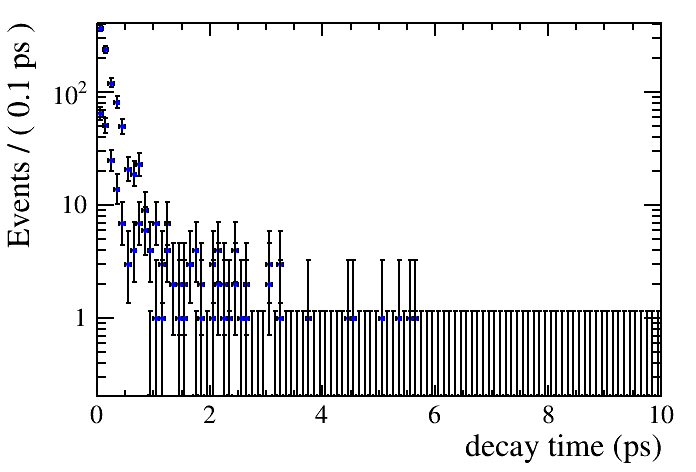

In [3]:
SIMEVTS = 1000#00
NTOYS = 1000
truesigyield = SIMEVTS*(sigyield.getVal()/(sigyield.getVal()+bkgyield.getVal()))
def gentoy():
    toydata = combPDF.generate(RooArgSet(bdt,mass,time),SIMEVTS)
    return toydata
toydata = gentoy()
from ROOT import TCanvas, RooCmdArg
from ROOT.RooFit import Cut
c = TCanvas()
frame = time.frame()
toydata.plotOn(frame)
smalldata = toydata.reduce(Cut("BDT>0.5"))
smalldata.plotOn(frame)#,Cut("BDT>0.5"))
frame.Draw()
c.SetLogy()
c.Draw()
destruct_object(toydata)
destruct_object(smalldata)

For automisation, a few helper functions: resetting fit parameters, fitting the toy data (with possible cut on the BDT - the efficiency for the signal as function of cut value is perfectly known, as well as the true signal expected yield), determination of pull in yield and bias.

For each toy, a scan over BDT cut values is performed (in steps of 0.1) to pick the best cut value (this is the one with the smallest uncertainty on the signal yield before cut).

In [ ]:
from ROOT import RooMsgService
def reset():
    bkgyield.setMin(by_min)
    bkgyield.setMin(by_min)
    bkgyield.setMax(by_max)
    bkgyield.setMax(by_max)
    bkgyield.setVal(by_start)
    sigyield.setMin(sy_min)
    sigyield.setMin(sy_min)
    sigyield.setMax(sy_max)
    sigyield.setMax(sy_max)
    sigyield.setVal(sy_start)
    blifetime.setVal(time_central)
    blifetime.setMin(time_min)
    blifetime.setMax(time_max)

def fitwithcut(dataset,cutvalue):
    reset()
    smalldata = dataset.reduce(Cut("BDT>"+str(cutvalue)))
    combmPDF.fitTo(smalldata,RooFit.Save(False),RooFit.NumCPU(2),RooFit.PrintLevel(-1000))
    from RooStats import SPlot
    splot = SPlot("splot","splot",smalldata,combmPDF,RooArgList(sigyield,bkgyield))
    from ROOT import RooDataSet
    sdata = RooDataSet("newdata","newdata",smalldata,data.get(),0,"sigyield_sw")
    btimePDF.fitTo(sdata,RooFit.Save(False),RooFit.NumCPU(2),RooFit.PrintLevel(-1000))
    #fitres.Print("V")
    destruct_object(smalldata)
    destruct_object(newdata)
    val, err = sigyield.getVal(),sigyield.getError()
    tval, terr = blifetime.getVal(),blifetime.getError()
    sy = val/(1.-cutvalue)
    se = err/(1.-cutvalue)
    return sy,se,tval,terr

def fitonlymasswithcut(dataset,cutvalue):
    reset()
    smalldata = dataset.reduce(Cut("BDT>"+str(cutvalue)))
    fitres = combmPDF.fitTo(smalldata,RooFit.Save(False),RooFit.NumCPU(2),RooFit.PrintLevel(-1000))
    #fitres.Print("V")
    destruct_object(smalldata)
    val, err = sigyield.getVal(),sigyield.getError()
    sy = val/(1.-cutvalue)
    se = err/(1.-cutvalue)
    return sy,se
                            

def runtoy():
    reset()
    toydata = gentoy()
    RooMsgService.instance().setGlobalKillBelow(RooFit.WARNING)
    cutval = 0.0
    sy,se,tc,te = fitwithcut(toydata,cutval)
    
    res = sy-truesigyield
    pull = res/se
    
    cutval = 0.5
    sy2,se2,tc2,te2 = fitwithcut(toydata,cutval)
    res2 = sy2-truesigyield
    pull2 = res2/se2
    
    by,be,timebest,timeerror = sy,se,tc,te
    for tv in [0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
        ### TODO: do only mass fit here!
        y,e = fitonlymasswithcut(toydata,tv)
        if e/y < be/by:
            by,be = y,e
            delme,delmetoo,timebest,timeerror = fitwithcut(toydata,tv)
    resbest = by-truesigyield
    pullbest = resbest/be
    destruct_object(toydata)
    
    return res,pull,res2,pull2, resbest,pullbest,(tc,te,tc2,te2,timebest,timeerror)

Now, run many toys, record the pulls and residuals for "no cut", "cut at 0.5", and "best cut".

In [ ]:
from ROOT import TH1F, RooRandom
pullhist = TH1F("pullhist","pulls without BDT cut",100,-10,10)
pull2hist = TH1F("pull2hist","pulls with BDT cut",100,-10,10)
pullbhist = TH1F("pullbhist","pulls with best BDT cut",100,-10,10)
reshist = TH1F("reshist","residuals without BDT cut",300,-800,800)
res2hist = TH1F("res2hist","residuals with BDT cut",300,-800,800)
resbhist = TH1F("resbhist","residuals with best BDT cut",300,-800,800)

timepullhist = TH1F("timepullhist","time pulls without BDT cut",100,-10,10)
timepull2hist = TH1F("timepull2hist","time pulls with BDT cut",100,-10,10)
timepullbhist = TH1F("timepullbhist","time pulls with best BDT cut",100,-10,10)
timereshist = TH1F("timereshist","time residuals without BDT cut",300,-800,800)
timeres2hist = TH1F("timeres2hist","time residuals with BDT cut",300,-800,800)
timeresbhist = TH1F("timeresbhist","time residuals with best BDT cut",300,-800,800)

for i in xrange(NTOYS):
    print ".",
    RooRandom.randomGenerator().SetSeed(i)
    res,pull,res2,pull2,resb,pullb,timestuff = runtoy()
    pullhist.Fill(pull)
    pull2hist.Fill(pull2)
    pullbhist.Fill(pullb)
    reshist.Fill(res)
    res2hist.Fill(res2)
    resbhist.Fill(resb)
    timereshist.Fill(timestuff[0]-time_central)
    timepullhist.Fill((timestuff[0]-time_central)/timestuff[1])
    timeres2hist.Fill(timestuff[2]-time_central)
    timepull2hist.Fill((timestuff[2]-time_central)/timestuff[3])
    timeresbhist.Fill(timestuff[4]-time_central)
    timepullbhist.Fill((timestuff[4]-time_central)/timestuff[5])
cc = TCanvas()
cc.Divide(3,2)
cc.cd(1)
pullhist.Draw()
cc.cd(2)
pull2hist.Draw()
cc.cd(3)
pullbhist.Draw()
cc.cd(4)
reshist.Draw()
cc.cd(5)
res2hist.Draw()
cc.cd(6)
resbhist.Draw()
cc.Draw()
ccc = TCanvas()
ccc.Divide(3,2)
ccc.cd(1)
timepullhist.Draw()
ccc.cd(2)
timepull2hist.Draw()
ccc.cd(3)
timepullbhist.Draw()
ccc.cd(4)
timereshist.Draw()
ccc.cd(5)
timeres2hist.Draw()
ccc.cd(6)
timeresbhist.Draw()
ccc.Draw()


Let's have a look. The scenario "no cut" and the scenario with the fixed cut seem unbiased. But when always picking the best cut value, on seems to be off by 10 σ!

In [ ]:
print "resolution without cut is        ", reshist.GetRMS()
print "bias without cut is              ", pullhist.GetMean(), u"±", pullhist.GetMeanError()
print "resolution with cut at 0.5 is    ", res2hist.GetRMS()
print "bias with cut at 0.5 is          ", pull2hist.GetMean(), u"±", pull2hist.GetMeanError()
print "resolution with optimised cut is ", resbhist.GetRMS()
print "bias with optimised cut is       ", pullbhist.GetMean(), u"±", pullbhist.GetMeanError()


In [ ]:
print "time resolution without cut is        ", timereshist.GetRMS()
print "time bias without cut is              ", timepullhist.GetMean(), u"±", timepullhist.GetMeanError()
print "time resolution with cut at 0.5 is    ", timeres2hist.GetRMS()
print "time bias with cut at 0.5 is          ", timepull2hist.GetMean(), u"±", timepull2hist.GetMeanError()
print "time resolution with optimised cut is ", timeresbhist.GetRMS()
print "time bias with optimised cut is       ", timepullbhist.GetMean(), u"±", timepullbhist.GetMeanError()
